In [1]:
# Import necessary libraries
import numpy as np
import sys
import time

from PIL import Image
import PIL

In [2]:
import tensorflow as tf

# from tensorflow import keras
import keras

Using TensorFlow backend.


In [3]:
from keras.layers import Input, InputLayer, Flatten, Activation, Dense, Conv2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [4]:
from keras.activations  import *
from keras.models       import Model, Sequential
from keras.applications import vgg16, imagenet_utils

import keras.backend as K

In [5]:
import math
import matplotlib.pyplot as plt

In [6]:
class DConvolution2D(object):
    
    def __init__(self, layer):

        self.layer = layer

        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]

        filters = W.shape[3]

        up_row = W.shape[0]
        up_col = W.shape[1]
        
        input_img = Input(shape = layer.input_shape[1:])

        output = Conv2D(filters, (up_row, up_col), 
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b),
                        padding='same'
                        )(input_img)
        
        self.up_func = K.function([input_img, K.learning_phase()], [output])
        
        # Deconv filter (exchange no of filters and depth of each filter)
        W = np.transpose(W, (0,1,3,2))
        
        # Reverse columns and rows
        W = W[::-1, ::-1,:,:]
        
        down_filters = W.shape[3]
        down_row = W.shape[0]
        down_col = W.shape[1]
        
        b = np.zeros(down_filters)
        
        input_d = Input(shape = layer.output_shape[1:])

        output = Conv2D(down_filters, (down_row, down_col),
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b),
                        padding = 'same'
                       )(input_d)
        
        self.down_func = K.function([input_d, K.learning_phase()], [output])

    def up(self, data, learning_phase = 0):
        #Forward pass
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data, axis=0)
        self.up_data = np.expand_dims(self.up_data, axis=0)
        
        # print(self.up_data.shape)
        return self.up_data

    def down(self, data, learning_phase = 0):
        # Backward pass
        self.down_data = self.down_func([data, learning_phase])
        self.down_data = np.squeeze(self.down_data, axis=0)
        self.down_data = np.expand_dims(self.down_data, axis=0)
        
        # print(self.down_data.shape)
        return self.down_data

In [7]:
class DActivation(object):
    def __init__(self, layer, linear = False):
        
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        
        input = K.placeholder(shape = layer.output_shape)

        output = self.activation(input)
        
        # According to the original paper, 
        # In forward pass and backward pass, do the same activation(relu)
        
        # Up method
        self.up_func = K.function([input, K.learning_phase()], [output])
        
        # Down method
        self.down_func = K.function([input, K.learning_phase()], [output])
   
    def up(self, data, learning_phase = 0):
        
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data,axis=0)
        self.up_data = np.expand_dims(self.up_data,axis=0)
        
        print(self.up_data.shape)
        return self.up_data
   
    def down(self, data, learning_phase = 0):
        
        self.down_data = self.down_func([data, learning_phase])
        self.down_data = np.squeeze(self.down_data,axis=0)
        self.down_data = np.expand_dims(self.down_data,axis=0)
        
        print(self.down_data.shape)
        return self.down_data

In [8]:
class DInput(object):

    def __init__(self, layer):
        self.layer = layer
    
    # input and output of Inputl layer are the same
    def up(self, data, learning_phase = 0):
 
        self.up_data = data
        return self.up_data
    
    def down(self, data, learning_phase = 0):

        # data = np.squeeze(data,axis=0)
        data = np.expand_dims(data,axis=0)
        self.down_data = data
        return self.down_data

In [9]:
class DDense(object):
  
    def __init__(self, layer):

        self.layer = layer
        
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]
        
        # Up method
        input = Input(shape = layer.input_shape[1:])
        
        output = Dense( layer.output_shape[1],
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b)
                      )(input)
        
        self.up_func = K.function([input, K.learning_phase()], [output])
        
        #Transpose W  for down method
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        
        b = np.zeros(self.input_shape[1])
        flipped_weights = [W, b]
        
        input = Input(shape = self.output_shape[1:])
        
        output = Dense( self.input_shape[1:],
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b)
                      )(input)
        
        self.down_func = K.function([input, K.learning_phase()], [output])

    def up(self, data, learning_phase = 0):
        
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data,axis=0)
        self.up_data = np.expand_dims(self.up_data,axis=0)
        
        print(self.up_data.shape)
        return self.up_data
        
    def down(self, data, learning_phase = 0):
    
        self.down_data = self.down_func([data, learning_phase])
        self.down_data = np.squeeze(self.down_data,axis=0)
        self.down_data = np.expand_dims(self.down_data,axis=0)
        
        print(self.down_data.shape)
        return self.down_data

In [10]:
class DFlatten(object):

    def __init__(self, layer):
   
        self.layer = layer
        self.shape = layer.input_shape[1:]
        
        self.up_func = K.function([layer.input, K.learning_phase()], [layer.output])

    # Flatten 2D input into 1D output
    def up(self, data, learning_phase = 0):
        
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data,axis=0)
        self.up_data = np.expand_dims(self.up_data,axis=0)

        print(self.up_data.shape)
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data, learning_phase = 0):

        new_shape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.down_data = np.reshape(data, new_shape)
        return self.down_data

In [11]:
class DPooling(object):

    def __init__(self, layer):

        self.layer = layer
        self.poolsize = layer.pool_size
       
    
    def up(self, data, learning_phase = 0):

        [self.up_data, self.switch] = self.__max_pooling_with_switch(data, self.poolsize)
        return self.up_data

    def down(self, data, learning_phase = 0):
      
        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        return self.down_data
    
    def __max_pooling_with_switch(self, input, poolsize):

        switch = np.zeros(input.shape)
        out_shape = list(input.shape)
        
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        print(row_poolsize)
        print(col_poolsize)
        
        out_shape[1] = math.floor(out_shape[1] / poolsize[0])
        out_shape[2] = math.floor(out_shape[2] / poolsize[1])
        print(out_shape)
        
        pooled = np.zeros(out_shape)
        
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                for row in range(out_shape[1]):
                    for col in range(out_shape[2]):
                        
                        patch = input[sample, 
                                row * row_poolsize : (row + 1) * row_poolsize,
                                col * col_poolsize : (col + 1) * col_poolsize,
                                dim]
                        
                        max_value = patch.max()
                        pooled[sample, row, col,dim] = max_value
                        
                        max_col_index = patch.argmax(axis = 1)
                        max_cols = patch.max(axis = 1)
                        
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        
                        switch[sample, 
                                row * row_poolsize + max_row, 
                                col * col_poolsize + max_col,
                                dim] = 1
                        
        return [pooled, switch]
    
    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input, switch):

        print('switch '+str(switch.shape))
        print('input  '+str(input.shape))
        
        tile = np.ones((math.floor(switch.shape[1] / input.shape[1]), 
                        math.floor(switch.shape[2] / input.shape[2])))
        
        print('tile '+str(tile.shape))
        
        tile  = np.expand_dims(tile, axis=3)
        input = np.squeeze(input, axis=0)
        
        out = np.kron(input, tile)
        print('out '+str(out.shape))
        
        unpooled = out * switch
        unpooled = np.expand_dims(unpooled,axis=0)
        return unpooled

In [12]:
def visualize(model, data, layer_name, feature_to_visualize, visualize_mode):
    
    deconv_layers = []
    
    # Stack layers
    for i in range(len(model.layers)):
        
        if isinstance(model.layers[i], Convolution2D):
            
            deconv_layers.append(DConvolution2D(model.layers[i]))
            deconv_layers.append(DActivation(model.layers[i]))
            
        elif isinstance(model.layers[i], MaxPooling2D):
            
            deconv_layers.append(DPooling(model.layers[i]))
            
        elif isinstance(model.layers[i], Dense):
            
            deconv_layers.append(DDense(model.layers[i]))
            deconv_layers.append(DActivation(model.layers[i]))
            
        elif isinstance(model.layers[i], Activation):
            
            deconv_layers.append(DActivation(model.alyers[i]))
            
        elif isinstance(model.layers[i], Flatten):
            
            deconv_layers.append(DFlatten(model.layers[i]))
            
        elif isinstance(model.layers[i], InputLayer):
            
            deconv_layers.append(DInput(model.layers[i]))
        else:
            print('Cannot handle this type of layer')
            print(model.layers[i].get_config())
            sys.exit()
        if layer_name == model.layers[i].name:
            break

    # Forward pass
    deconv_layers[0].up(data)
    
    for i in range(1, len(deconv_layers)):
        deconv_layers[i].up(deconv_layers[i - 1].up_data)

    output = deconv_layers[-1].up_data
    print(output.shape)
    
    assert output.ndim == 2 or output.ndim == 4
    
    if output.ndim == 2:
        feature_map = output[:, feature_to_visualize]
    else:
        feature_map = output[:,:, :, feature_to_visualize]
    
    if 'max' == visualize_mode:
        
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp
        
    elif 'all' != visualize_mode:
        
        print('Illegal visualize mode')
        sys.exit()
    
    output = np.zeros_like(output)
    
    if 2 == output.ndim:
        output[:, feature_to_visualize] = feature_map
    else:
        output[:,: , :, feature_to_visualize] = feature_map

    
    # Backward pass
    deconv_layers[-1].down(output)
    
    for i in range(len(deconv_layers) - 2, -1, -1):
        deconv_layers[i].down(deconv_layers[i + 1].down_data)
    
    deconv = deconv_layers[0].down_data
    deconv = deconv.squeeze()

    return deconv

In [13]:
# image_path = "E:\GitHub\Transposed convolution Zeiler\kangaroo.jpg"
image_path = "Results/Deconvnet/kangaroo.jpg"

layer_name = 'block3_conv3'
feature_to_visualize = 127
visualize_mode = 'all'

In [14]:
model = vgg16.VGG16(weights = 'imagenet', include_top = True)

W0301 21:59:38.061108  6836 deprecation_wrapper.py:119] From g:\anaconda3\envs\gdl\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0301 21:59:38.078095  6836 deprecation_wrapper.py:119] From g:\anaconda3\envs\gdl\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0301 21:59:38.080092  6836 deprecation_wrapper.py:119] From g:\anaconda3\envs\gdl\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0301 21:59:38.108074  6836 deprecation_wrapper.py:119] From g:\anaconda3\envs\gdl\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0301 21:59:39.762906  6836 deprecation_wrapper.py:119] From g:\anaconda3\envs\gdl\lib\site

In [15]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
# Load data and preprocess
img = Image.open(image_path)
img = img.resize((224, 224),resample=PIL.Image.NEAREST)

img_array = np.array(img)
img_array = img_array[np.newaxis, :]
img_array = img_array.astype(np.float)
img_array = imagenet_utils.preprocess_input(img_array)

W0301 21:59:50.131134  6836 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


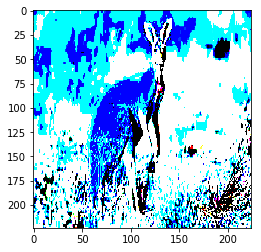

In [17]:
#Original image
plt.imshow(img_array[0])
plt.show()

In [18]:
deconv = visualize( model, img_array
                  , layer_name
                  , feature_to_visualize
                  , visualize_mode
                  )

(1, 224, 224, 64)
(1, 224, 224, 64)
2
2
[1, 112, 112, 64]
(1, 112, 112, 128)
(1, 112, 112, 128)
2
2
[1, 56, 56, 128]
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
switch (1, 112, 112, 128)
input  (1, 56, 56, 128)
tile (2, 2)
out (112, 112, 128)
(1, 112, 112, 128)
(1, 112, 112, 128)


g:\anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


switch (1, 224, 224, 64)
input  (1, 112, 112, 64)
tile (2, 2)
out (224, 224, 64)
(1, 224, 224, 64)
(1, 224, 224, 64)


W0301 22:00:41.824742  6836 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


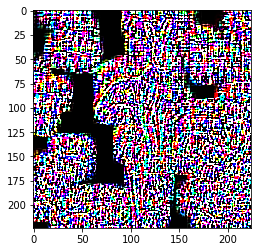

In [19]:
#After deconvolution-
plt.imshow(deconv)
plt.show()

In [20]:
print(deconv.shape)

# postprocess and save image

#deconv = np.transpose(deconv, ())
deconv = deconv - deconv.min()
deconv *= 1.0 / (deconv.max() + 1e-8)
#deconv = deconv[:, :, ::-1]

uint8_deconv = (deconv * 255).astype(np.uint8)

(224, 224, 3)


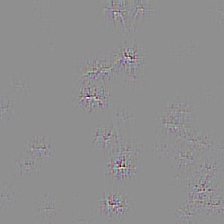

In [21]:
img = Image.fromarray(uint8_deconv, 'RGB')
img.save('Results/Deconvnet/kangaroo{}_{}_{}.png'.format(layer_name, feature_to_visualize, visualize_mode))
plt.imshow(img)
plt.show()